<a href="https://colab.research.google.com/github/shrestha94sujan/stocks_analysis/blob/master/stocks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
print('hello world of stocks!')

hello world of stocks!


**Installing yfinance api for importing the financial stuffs.**

In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=7fcdb45d09476af2cc1e230894ea8883e172ea4e687965c4136aff082758c2f5
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


**Adding import statements.**

In [11]:
import yfinance as yf

# Just get the AAPL stocks
aapl = yf.Ticker('AAPL')

#get historical market data
hist = aapl.history(period='15y')

#if you wish to look at the entire historical data for last 15 years!
print(hist)

              Open    High     Low   Close     Volume  Dividends  Stock Splits
Date                                                                          
2005-05-09    4.61    4.63    4.54    4.57   88923800       0.00           0.0
2005-05-10    4.54    4.61    4.49    4.50  110065900       0.00           0.0
2005-05-11    4.35    4.41    4.09    4.40  510495300       0.00           0.0
2005-05-12    4.38    4.40    4.20    4.22  242560500       0.00           0.0
2005-05-13    4.23    4.36    4.21    4.30  175678300       0.00           0.0
...            ...     ...     ...     ...        ...        ...           ...
2020-05-04  288.39  292.90  285.55  292.37   33392000       0.00           0.0
2020-05-05  294.26  300.19  293.67  296.76   36937800       0.00           0.0
2020-05-06  299.65  302.42  298.06  299.82   35583400       0.00           0.0
2020-05-07  302.40  304.35  301.15  302.92   28803800       0.00           0.0
2020-05-08  305.64  310.35  304.29  310.13   3345960

**Historical charts that shows opening and closing stock prices.**

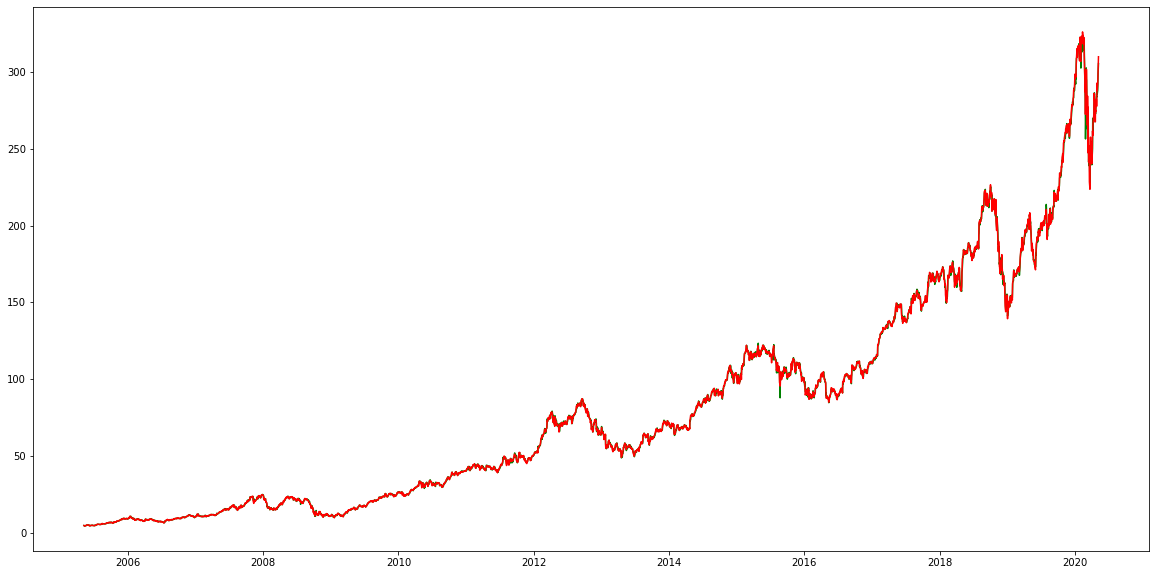

In [12]:
import matplotlib.pyplot as plt
import seaborn


#Plot Open and Close prices.
plt.figure(figsize=(20, 10))
plt.plot(hist['Open'], color='green')
plt.plot(hist['Close'], color='red')

